In [5]:
import GEODATA as gd

runways = gd.readRunways()
runways

,NAME,geometry
0,HERVEY BAY AERODROME,"LINESTRING (17019436.162 -2915603.032, 1701799..."
1,HERVEY BAY AERODROME,"LINESTRING (17019436.162 -2915603.032, 1701799..."
2,MARYBOROUGH AIRPORT,"LINESTRING (17000555.262 -2939311.867, 1700006..."
3,MARYBOROUGH AIRPORT,"LINESTRING (17000063.230 -2938923.317, 1699978..."
4,MARYBOROUGH AIRPORT,"LINESTRING (17000063.230 -2938923.317, 1699993..."
...,...,...
585,FORREST AERODROME,"LINESTRING (14261533.917 -3612866.068, 1426152..."
586,FORREST AERODROME,"LINESTRING (14261527.238 -3611605.826, 1426152..."
587,FORREST AERODROME,"LINESTRING (14261158.771 -3611583.785, 1426152..."
588,FORREST AERODROME,"LINESTRING (14261527.238 -3611605.826, 1426276..."


In [6]:
# Draw Exclusion zone
sydney = runways.loc[runways['NAME'] == 'SYDNEY AIRPORT']
sydney.reset_index(drop=True, inplace=True)
sydney

,NAME,geometry
0,SYDNEY AIRPORT,"LINESTRING (16830197.381 -4022025.447, 1683081..."
1,SYDNEY AIRPORT,"LINESTRING (16828271.555 -4019070.836, 1682868..."
2,SYDNEY AIRPORT,"LINESTRING (16828682.323 -4020875.447, 1682947..."
3,SYDNEY AIRPORT,"LINESTRING (16830355.455 -4020392.401, 1682868..."
4,SYDNEY AIRPORT,"LINESTRING (16828682.323 -4020875.447, 1682743..."


In [7]:
from shapely.geometry import LineString

def perpendicular(lineString, len, side):
    
    left = lineString.parallel_offset(len, 'left')
    right = lineString.parallel_offset(len, 'right')
    
    if (side == 'top'):
        
        leftEnd = left.boundary[1]
        rightEnd = right.boundary[0]
        return LineString([leftEnd, rightEnd])
    
    elif (side == 'bottom'):
        
        leftEnd = left.boundary[0]
        rightEnd = right.boundary[1]
        return LineString([leftEnd, rightEnd])
    
    else:
        
        raise ValueError("Invalid value for side")
    

lineString = sydney.at[0, 'geometry']
coords = list(lineString.coords)
b_len = 2890
c_len = 1760
d1_len = 5310
d2_len = 680

# Determine line
rise = (coords[1][1] - coords[0][1])
run = (coords[1][0] - coords[0][0])

# HORIZONTAL
if (rise == 0):
    
    # Exclusion Zone
    top = lineString.parallel_offset(c_len, 'left')
    bottom = lineString.parallel_offset(c_len, 'right')
    midPoly = top.buffer(-2*c_len, single_sided=True)
    right = perpendicular(lineString, c_len, 'top')
    rightPoly = right.buffer(b_len, single_sided=True)
    left = perpendicular(lineString, c_len, 'bottom')
    leftPoly = left.buffer(-b_len, single_sided=True)
    
    # Restriction Zone
    farLeft = []
    farLeft = (left.parallel_offset(d1_len, 'left')).centroid

# VERTICAL    
elif (run == 0):
    
    # Vertical line
    
    pass

# DIAGONAL
else:

    grad = rise / run
    b = (coords[0][1]) - (grad * coords[0][0])
    #y = grad*x + b

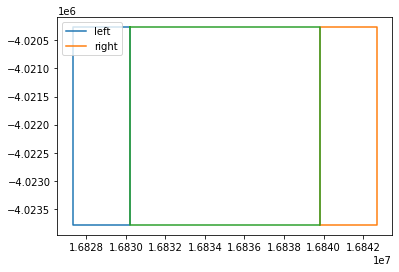

In [8]:
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

lineString = LineString([(16830197.38110897, -4022025.447476781), (16839816.317067254, -4022025.447476781)])

b_len = 2890
c_len = 1760
d_len = 5310
e_len = 680

# Horizontal line
top = lineString.parallel_offset(c_len, 'left')
bottom = lineString.parallel_offset(c_len, 'right')
midPoly = top.buffer(-2*c_len, single_sided=True)
right = perpendicular(lineString, c_len, 'top')
rightPoly = right.buffer(b_len, single_sided=True)
left = perpendicular(lineString, c_len, 'bottom')
leftPoly = left.buffer(-b_len, single_sided=True)

# Restriction Zone
#rstcCenterline = lineString.parallel

plt.plot(*leftPoly.exterior.xy, label='left')
plt.plot(*rightPoly.exterior.xy, label='right')
#plt.plot(*top.xy, label='top')
#plt.plot(*bottom.xy, label='bottom')
plt.plot(*midPoly.exterior.xy)
plt.legend(loc='upper left')
plt.show()

In [22]:
import shapely.geometry
from shapely import affinity
import geopandas as gpd


name = []
geometry = []

lineString = sydney.at[0, 'geometry']
name.append('Runway Centreline')
geometry.append(lineString)

# Exclusion zone
len = lineString.length
scale = (len + 2*b_len)/len 
lenPlus2b = affinity.scale(lineString, xfact=scale, yfact=scale)
left = lenPlus2b.parallel_offset(c_len, 'left')
exclusionZone = left.buffer(-2*c_len, single_sided=True)
name.append('Exclusion Zone')
geometry.append(exclusionZone)

# Restriction zone
scale = (len + 2*b_len + 2*d1_len)/len
rstLen = affinity.scale(lineString, xfact=scale, yfact=scale)
left = rstLen.parallel_offset(d2_len/2, 'left')
restrictionZone = left.buffer(-d2_len, single_sided=True)
name.append('Restriction Zone')
geometry.append(restrictionZone)

g = {'Polygon Name' : name , 'geometry': geometry}
polygons = gpd.GeoDataFrame(g, crs="EPSG:3857")
polygons.explore()
polygons.to_file('zones')

C:\Users\navni\AppData\Local\Temp\ipykernel_24432\3455020673.py:33: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygons.to_file('zones')
